<a href="https://colab.research.google.com/github/nihcas2015/SRIP_2025/blob/main/full_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install xgboost




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression


from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, f1_score
%matplotlib inline
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
data=pd.read_csv("/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_1.csv")
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_2.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_3.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_4.csv")])

/tmp/ipython-input-15-1392238074.py:1: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_1.csv")
/tmp/ipython-input-15-1392238074.py:2: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_2.csv")])
/tmp/ipython-input-15-1392238074.py:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_3.csv")])
/tmp/ipython-input-15-1392238074.py:4: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_4.csv")])


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5499318 entries, 0 to 1830795
Data columns (total 47 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   pkSeqID                           int64  
 1   stime                             float64
 2   flgs                              object 
 3   flgs_number                       float64
 4   proto                             object 
 5   proto_number                      float64
 6   saddr                             object 
 7   sport                             object 
 8   daddr                             object 
 9   dport                             object 
 10  pkts                              int64  
 11  bytes                             int64  
 12  state                             object 
 13  state_number                      float64
 14  ltime                             float64
 15  seq                               int64  
 16  dur                               float64

In [17]:
data.columns

Index(['pkSeqID', 'stime', 'flgs', 'flgs_number', 'proto', 'proto_number',
       'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state',
       'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min',
       'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate',
       'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto',
       'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP',
       'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport',
       'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP',
       'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory',
       'subcategory '],
      dtype='object')

In [18]:
data=data.drop(columns=["pkSeqID","stime","flgs","proto","saddr","sport","daddr","dport","state","ltime","seq"])

In [19]:
#dropping correlated columns
data=data.drop(columns=["bytes","max","spkts","sbytes","dbytes","AR_P_Proto_P_Dport","state_number","dpkts"])

In [20]:
data=data.drop_duplicates()

In [21]:
data.isnull().sum()

,0
flgs_number,150569
proto_number,150569
pkts,0
dur,0
mean,0
stddev,0
sum,0
min,0
rate,0
srate,0


In [11]:
data['category'].value_counts()

,count
category,
DDoS,1926624
Reconnaissance,1912721
DoS,1650260
Normal,8047
Theft,1666


In [12]:
data["attack"].value_counts()

,count
attack,
1,5491271
0,8047


In [13]:
data["subcategory"].value_counts()

,count
subcategory,
UDP,1981230
TCP,1593180
Service_Scan,73168
OS_Fingerprint,17914
HTTP,2474
Normal,477
Keylogging,73
Data_Exfiltration,6


In [ ]:
le = LabelEncoder()
data['category'] = le.fit_transform(data['category'])
data['subcategory'] = le.fit_transform(data['subcategory'])
data.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1,8,7.056393,0.068909,0.068909,0.137818,0.000000,0.992008,0.566862,...,1.142970,1.12704,96,75,1.133720,770,602,1,1,1
1,1,2,2,0.000131,0.000131,0.000000,0.000131,0.000131,7633.588379,0.000000,...,0.003857,15267.20000,1,2,0.005142,2,6,1,1,1
2,1,1,8,7.047852,0.064494,0.064494,0.128988,0.000000,0.993210,0.567549,...,1.142970,1.12704,96,75,1.135100,770,602,1,1,1
3,1,1,8,7.047592,0.064189,0.064189,0.128378,0.000000,0.993247,0.567570,...,1.142970,1.12704,96,75,1.135140,770,602,1,1,1
4,1,1,8,7.046841,0.063887,0.063887,0.127774,0.000000,0.993353,0.567630,...,1.142970,1.12704,96,75,1.135260,770,602,1,1,1


In [ ]:
Y = data[['attack','category','subcategory']]
X= data.drop(['attack','category','subcategory'],axis=1)

In [ ]:
X.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP
0,1,1,8,7.056393,0.068909,0.068909,0.137818,0.000000,0.992008,0.566862,...,770,772,772,1.142970,1.12704,96,75,1.133720,770,602
1,1,2,2,0.000131,0.000131,0.000000,0.000131,0.000131,7633.588379,0.000000,...,2,8,8,0.003857,15267.20000,1,2,0.005142,2,6
2,1,1,8,7.047852,0.064494,0.064494,0.128988,0.000000,0.993210,0.567549,...,770,772,772,1.142970,1.12704,96,75,1.135100,770,602
3,1,1,8,7.047592,0.064189,0.064189,0.128378,0.000000,0.993247,0.567570,...,770,772,772,1.142970,1.12704,96,75,1.135140,770,602
4,1,1,8,7.046841,0.063887,0.063887,0.127774,0.000000,0.993353,0.567630,...,770,772,772,1.142970,1.12704,96,75,1.135260,770,602


In [ ]:
mi_attack = mutual_info_classif(X, Y["attack"])
mi_subcat = mutual_info_classif(X, Y["subcategory"])
mi_cat    = mutual_info_classif(X, Y["category"])
mi_avg = (mi_attack + mi_subcat + mi_cat) / 3

df_mi = pd.DataFrame({
    'feature': X.columns.tolist(),
    'MI_attack': mi_attack,
    'MI_subcategory': mi_subcat,
    'MI_category': mi_cat,
    'MI_average': mi_avg
})

df_mi_sorted = df_mi.sort_values(by='MI_average', ascending=False)
top_features = df_mi_sorted.head(20)['feature'].tolist()
X = X[top_features]


In [ ]:
X.head()

,AR_P_Proto_P_DstIP,dur,AR_P_Proto_P_SrcIP,srate,AR_P_Proto_P_Sport,rate,proto_number,sum,mean,flgs_number,TnBPDstIP,stddev,TnBPSrcIP,TnP_Per_Dport,N_IN_Conn_P_DstIP,TnP_PerProto,TnP_PDstIP,Pkts_P_State_P_Protocol_P_DestIP,min,Pkts_P_State_P_Protocol_P_SrcIP
0,1.12704,7.056393,1.142970,0.566862,1.133720,0.992008,1,0.137818,0.068909,1,201841,0.068909,157426,772,96,772,770,770,0.000000,602
1,15267.20000,0.000131,0.003857,0.000000,0.005142,7633.588379,2,0.000131,0.000131,1,120,0.000000,360,8,1,8,2,2,0.000131,6
2,1.12704,7.047852,1.142970,0.567549,1.135100,0.993210,1,0.128988,0.064494,1,201841,0.064494,157426,772,96,772,770,770,0.000000,602
3,1.12704,7.047592,1.142970,0.567570,1.135140,0.993247,1,0.128378,0.064189,1,201841,0.064189,157426,772,96,772,770,770,0.000000,602
4,1.12704,7.046841,1.142970,0.567630,1.135260,0.993353,1,0.127774,0.063887,1,201841,0.063887,157426,772,96,772,770,770,0.000000,602


In [ ]:
model = XGBClassifier(tree_method='hist', n_jobs=-1)
model.fit(X, Y["attack"])

model1 = XGBClassifier(tree_method='hist', n_jobs=-1)
model1.fit(X, Y["subcategory"])

model2 = XGBClassifier(tree_method='hist', n_jobs=-1)
model2.fit(X, Y["category"])


importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features = importance_df['feature'].head(15)

importances = model1.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features1 = importance_df['feature'].head(15)

importances = model2.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features2 = importance_df['feature'].head(15)


combined_features = set(top_features) | set(top_features1) | set(top_features2)
X = X[list(combined_features)]

In [ ]:
X.head()

,rate,TnBPSrcIP,TnBPDstIP,Pkts_P_State_P_Protocol_P_SrcIP,TnP_PDstIP,proto_number,TnP_Per_Dport,mean,AR_P_Proto_P_DstIP,Pkts_P_State_P_Protocol_P_DestIP,dur,N_IN_Conn_P_DstIP,flgs_number,AR_P_Proto_P_Sport,AR_P_Proto_P_SrcIP,sum,stddev,srate,TnP_PerProto
0,0.992008,157426,201841,602,770,1,772,0.068909,1.12704,770,7.056393,96,1,1.133720,1.142970,0.137818,0.068909,0.566862,772
1,7633.588379,360,120,6,2,2,8,0.000131,15267.20000,2,0.000131,1,1,0.005142,0.003857,0.000131,0.000000,0.000000,8
2,0.993210,157426,201841,602,770,1,772,0.064494,1.12704,770,7.047852,96,1,1.135100,1.142970,0.128988,0.064494,0.567549,772
3,0.993247,157426,201841,602,770,1,772,0.064189,1.12704,770,7.047592,96,1,1.135140,1.142970,0.128378,0.064189,0.567570,772
4,0.993353,157426,201841,602,770,1,772,0.063887,1.12704,770,7.046841,96,1,1.135260,1.142970,0.127774,0.063887,0.567630,772


In [ ]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [ ]:
X_train.shape

(2934817, 19)

In [ ]:
# class RandomForest:
#     def __init__(self,max_depth):
#         self.rfc_attack = RandomForestClassifier(max_depth=max_depth)
#         self.rfc_category = RandomForestClassifier(max_depth=max_depth)
#         self.rfc_subcategory = RandomForestClassifier(max_depth=max_depth)

#     def fit(self,X_train,y_train):
#         self.rfc_attack.fit(X_train,y_train['attack'])

#         features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
#         self.rfc_category.fit(features_category,y_train['category'])

#         features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
#         self.rfc_subcategory.fit(features_subcategory,y_train['subcategory'])

#     def predict(self,X_test):
#         predict_attack = self.rfc_attack.predict(X_test)

#         test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
#         predict_category = self.rfc_category.predict(test_category)

#         test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
#         predict_subcategory = self.rfc_subcategory.predict(test_subcategory)



#         return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory})

In [ ]:
def display_metrics(y_true, y_pred, title,y_proba=None):
  print(f"--- {title} ---")
  print("\nClassification Report:")
  report = classification_report(y_true, y_pred, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print(df[:-3])

  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title(f"Confusion Matrix for {title}")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

  acc = accuracy_score(y_true, y_pred)
  print(f"\nAccuracy: {acc:.4f}")

    # Weighted F1 Score
  f1 = f1_score(y_true, y_pred, average='weighted')
  print(f"Weighted F1 Score: {f1:.4f}")

  if y_proba is not None:
        # Check if binary classification
        unique_classes = pd.Series(y_true).nunique()
        if unique_classes == 2:
            # ROC AUC
            roc_auc = roc_auc_score(y_true, y_proba)
            print(f"ROC AUC Score: {roc_auc:.4f}")

            # Precision-Recall AUC
            pr_auc = average_precision_score(y_true, y_proba)
            print(f"PR AUC Score: {pr_auc:.4f}")

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend()
            plt.grid(True)
            plt.show()

            # Precision-Recall Curve
            precision, recall, _ = precision_recall_curve(y_true, y_proba)
            plt.figure()
            plt.plot(recall, precision, label=f"AP = {pr_auc:.2f}")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Precision-Recall Curve")
            plt.legend()
            plt.grid(True)
            plt.show()



**Random Forest**

In [ ]:
# rf = RandomForest(max_depth=3)
# rf.fit(X_train,y_train)

# predictions_rfc = rf.predict(X_test)

# y_proba = rf.predict_proba(X_test)[:, 1]

AttributeError: 'RandomForest' object has no attribute 'predict_proba'

In [ ]:
# display_metrics(y_test['attack'], predictions_rfc['attack'], "Attack Prediction",y_proba)



In [ ]:
# display_metrics(y_test['category'], predictions_rfc['category'], "Category Prediction")


In [ ]:
# display_metrics(y_test['subcategory'], predictions_rfc['subcategory'], "Subcategory Prediction")

XGB graddient boosting


In [ ]:
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# # Train the model
# xgb_model.fit(X_train, y_train["attack"])

# # Predict
# y_pred_xgb = xgb_model.predict(X_test)

# y_proba = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:22:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Attack Prediction ---

Classification Report:
   precision    recall  f1-score   support
0   1.000000  0.978947  0.989362      95.0
1   0.999997  1.000000  0.999999  733610.0


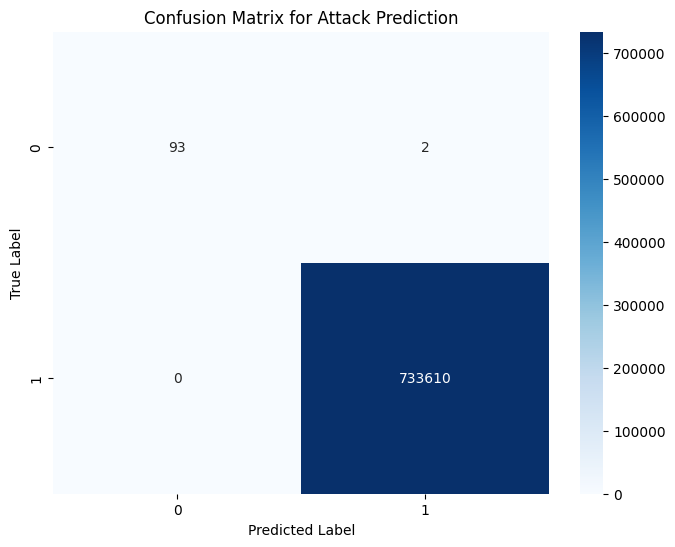


Accuracy: 1.0000
Weighted F1 Score: 1.0000
ROC AUC Score: 1.0000
PR AUC Score: 1.0000


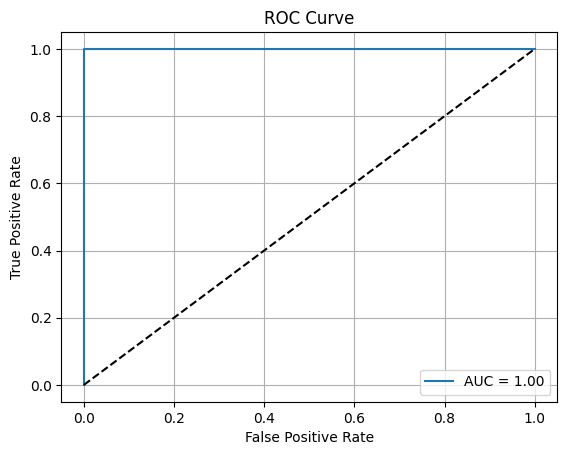

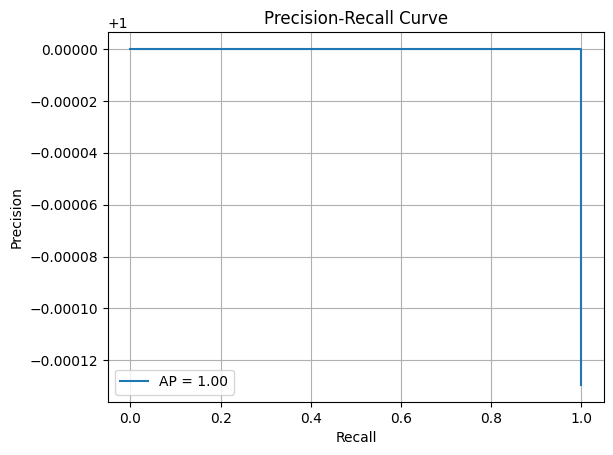

In [ ]:
# display_metrics(y_test['attack'], y_pred_xgb, "Attack Prediction",y_proba)


In [ ]:
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# # Train the model
# xgb_model.fit(X_train, y_train["category"])

# # Predict
# y_pred_xgb = xgb_model.predict(X_test)



In [ ]:
# display_metrics(y_test['category'], y_pred_xgb, "Category Prediction")

In [ ]:
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# # Train the model
# xgb_model.fit(X_train, y_train["subcategory"])

# # Predict
# y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
# display_metrics(y_test['subcategory'], y_pred_xgb, "Subcategory Prediction")

Logistic Regression


In [ ]:
# logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# # Train the model
# logreg_model.fit(X_train, y_train["attack"])

# # Predict
# y_pred_logreg = logreg_model.predict(X_test)

# y_proba = logreg_model.predict_proba(X_test)[:, 1]

--- Attack Prediction ---

Classification Report:
   precision    recall  f1-score   support
0   0.986842  0.789474  0.877193      95.0
1   0.999973  0.999999  0.999986  733610.0


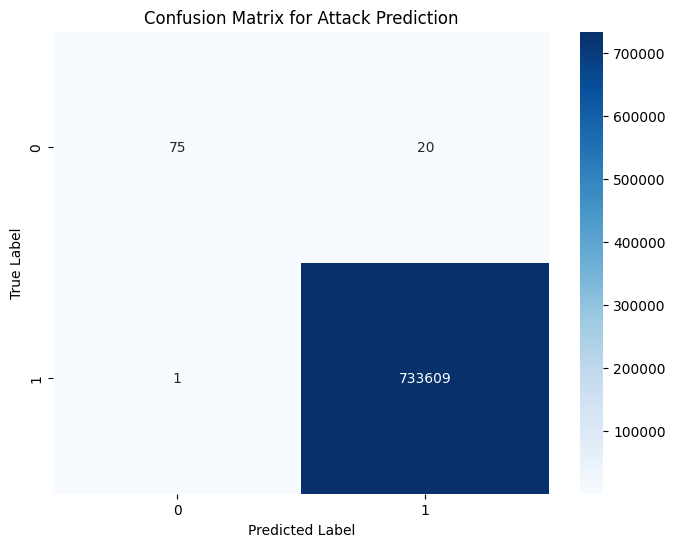


Accuracy: 1.0000
Weighted F1 Score: 1.0000
ROC AUC Score: 0.9999
PR AUC Score: 1.0000


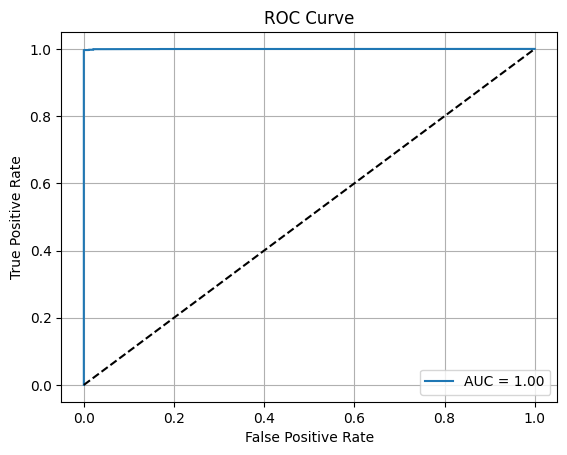

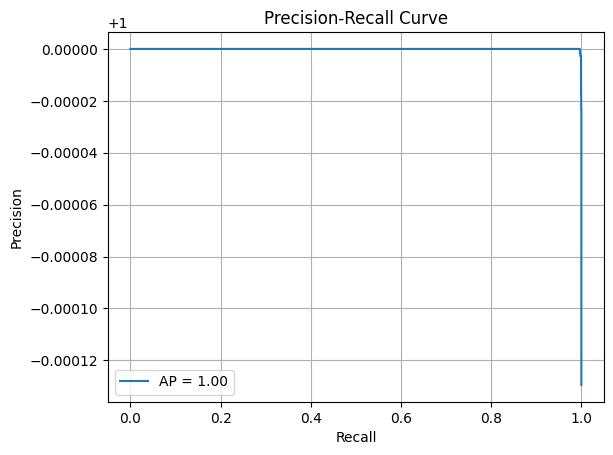

In [ ]:
# display_metrics(y_test['attack'], y_pred_logreg, "Attack Prediction",y_proba)


In [ ]:
# logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# # Train the model
# logreg_model.fit(X_train, y_train["category"])

# # Predict
# y_pred_logreg = logreg_model.predict(X_test)


In [ ]:
# display_metrics(y_test['category'], y_pred_logreg, "Category Prediction")

In [ ]:
# logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# # Train the model
# logreg_model.fit(X_train, y_train["subcategory"])

# # Predict
# y_pred_logreg = logreg_model.predict(X_test)

In [ ]:
# display_metrics(y_test['subcategory'], y_pred_logreg, "Subcategory Prediction")

Stacked Model

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
rf = RandomForestClassifier()


meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=200)


stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=5
)


stacked.fit(X_train, y_train["attack"])



In [ ]:
y_pred = stacked.predict(X_test)

display_metrics(y_test["subcategory"], y_pred, title="Subcategory")



In [ ]:
stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=5
)


stacked.fit(X_train, y_train["attack"])
y_pred = stacked.predict(X_test)
display_metrics(y_test["attack"], y_pred,title="Attack")



In [ ]:
stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=5
)


stacked.fit(X_train, y_train["category"])
y_pred = stacked.predict(X_test)
display_metrics(y_test["category"], y_pred,title="category")

